#Portfolio Optimization and their VaR

In this project, we are developing two types of portfolios: a minimum variance portfolio and a tendency portfolio. We will compare the Sharpe ratios and associated risks and returns of these two portfolios. Following this, we will optimize the portfolios to achieve a desired return. Additionally, we will calculate the Value at Risk (VaR) for each portfolio. Finally, we will use Stochastic Differential Equations to simulate the price/value changes of the portfolios and individual assets over a three-month period, based on historical volatility and drift.   

In [2]:
import numpy as np
import datetime as dt
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365*7)

In [4]:
tickers = ['TSLA', 'AAPL','NVDA','TSM','ABEV','VTEB','V', 'AMD','BA']


In [5]:
quotes = pd.DataFrame()
for ticker in tickers:
    quotes[ticker] = yf.download(ticker, start_date, end_date)['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
quotes.head(3)

TSLA       AAPL      NVDA        TSM      ABEV       VTEB  \
Date                                                                         
2017-06-26  25.166000  34.170929  3.757296  30.422812  4.284399  44.166977   
2017-06-27  24.158001  33.681156  3.619746  29.547092  4.260988  44.115582   
2017-06-28  24.749332  34.173267  3.747418  29.766024  4.307811  44.072754   

                    V    AMD          BA  
Date                                      
2017-06-26  90.772423  14.08  188.436584  
2017-06-27  90.467377  13.40  187.409485  
2017-06-28  91.735252  13.23  188.097366

In [7]:
log_return = np.log(quotes / quotes.shift(1)).dropna()
returns = quotes.pct_change().dropna()
returns.head(3)

TSLA      AAPL      NVDA       TSM      ABEV      VTEB  \
Date                                                                     
2017-06-27 -0.040054 -0.014333 -0.036609 -0.028785 -0.005464 -0.001164   
2017-06-28  0.024478  0.014611  0.035271  0.007410  0.010989 -0.000971   
2017-06-29 -0.028257 -0.014743 -0.033410 -0.015276 -0.009058 -0.002916   

                   V       AMD        BA  
Date                                      
2017-06-27 -0.003361 -0.048295 -0.005451  
2017-06-28  0.014015 -0.012687  0.003670  
2017-06-29 -0.018809 -0.047619 -0.010821

In [8]:
port_returns = ((1+returns).prod())**(252/len(returns))-1
port_returns

TSLA    0.328968
AAPL    0.295053
NVDA    0.655589
TSM     0.283949
ABEV   -0.098399
VTEB    0.018697
V       0.172338
AMD     0.418337
BA     -0.009288
dtype: float64

To understand the correlation between different stocks/assets in a portfolio, we calculate the covariance matrix. This matrix helps measure how the returns of each pair of stocks move together. Specifically, the covariance between two stocks indicates whether their returns tend to move in the same direction (positive covariance) or in opposite directions (negative covariance).

The covariance matrix is structured as follows:Diagonal elements: These represent the variance of each stock, which measures how much the stock's returns fluctuate over time. Off-diagonal elements: These represent the covariance between pairs of stocks, indicating the degree to which the returns of two stocks move together.

For simplicity, let's consider a portfolio with two stocks: Stock X and Stock Y. To calculate the covariance between these two assets, we can use the following formula. This formula can also be extended to higher dimensions or a larger number of assets.


$$ \text{Cov}(X, Y) = \frac{1}{n} \sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y}) $$

Matrix represenatation of covariance matrix with n assets:
$$
\mathbf{\Sigma} = \begin{pmatrix}
\sigma_{11} & \sigma_{12} & \cdots & \sigma_{1n} \\
\sigma_{21} & \sigma_{22} & \cdots & \sigma_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
\sigma_{n1} & \sigma_{n2} & \cdots & \sigma_{nn}
\end{pmatrix}
$$


In [9]:
#Covariance matrix
cov_matrix = log_return.cov()*252
cov_matrix

TSLA      AAPL      NVDA       TSM      ABEV      VTEB         V  \
TSLA  0.376704  0.086060  0.136043  0.078397  0.044585  0.003998  0.057133   
AAPL  0.086060  0.092719  0.093091  0.055446  0.030625  0.002871  0.048290   
NVDA  0.136043  0.093091  0.252805  0.108322  0.039918  0.004070  0.069749   
TSM   0.078397  0.055446  0.108322  0.112347  0.037519  0.003121  0.041072   
ABEV  0.044585  0.030625  0.039918  0.037519  0.132416  0.002529  0.031808   
VTEB  0.003998  0.002871  0.004070  0.003121  0.002529  0.003417  0.002528   
V     0.057133  0.048290  0.069749  0.041072  0.031808  0.002528  0.067773   
AMD   0.130681  0.085541  0.190797  0.101145  0.041055  0.004341  0.063664   
BA    0.087770  0.057318  0.080803  0.056150  0.059637  0.009343  0.059405   

           AMD        BA  
TSLA  0.130681  0.087770  
AAPL  0.085541  0.057318  
NVDA  0.190797  0.080803  
TSM   0.101145  0.056150  
ABEV  0.041055  0.059637  
VTEB  0.004341  0.009343  
V     0.063664  0.059405  
AMD   0.292549  0.075845  
BA    0.075845  0.208090

In [10]:
#this is the diagonal elements of the covarinace matrix
var = log_return.var()*252
var

TSLA    0.376704
AAPL    0.092719
NVDA    0.252805
TSM     0.112347
ABEV    0.132416
VTEB    0.003417
V       0.067773
AMD     0.292549
BA      0.208090
dtype: float64

In [11]:
#create a list with all one's. This is the vectors of 1
marten_matrix = np.ones(len(port_returns))
marten_matrix

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

#Minimum Variance Portfolio (MVP)
A minimum variance portfolio is a selection of assets that aims to minimize the overall volatility or risk of the portfolio. It achieves this by carefully allocating investments across different assets based on their historical volatilities, expected returns, and correlations with each other. The goal is to construct a portfolio where the assets' movements offset each other as much as possible, reducing the portfolio's overall risk.

Investors often use minimum variance portfolios when they prioritize capital preservation and aim to minimize downside risk. These portfolios are particularly relevant in volatile markets or for risk-averse investors who prioritize stability and are willing to accept potentially lower returns in exchange for reduced risk.

**Minimum Variance Portfilio Weight**

$$
\text{MPV_weight} = \frac{\Sigma^{-1} \mathbf{1}}{\sum_{i=1}^{n} \mathbf{1}    (\Sigma^{-1}\mathbf{1})}
$$
where,
$$\Sigma^{-1}\, \text{is the inverse of covariance matrix.} $$
$$\mathbf{1} \,\text{ is the matrix of 1's} $$

In [12]:
mvp_weight = (np.matmul(np.linalg.inv(cov_matrix), marten_matrix)) / np.sum(
    np.matmul((np.matmul(marten_matrix, np.linalg.inv(cov_matrix))) , marten_matrix))

print(f'Portfolio weignts are : {mvp_weight}')

Portfolio weignts are : [ 4.50025782e-04  1.12048678e-02 -6.54538596e-03  8.76429260e-03
  1.38325318e-02  9.82980663e-01  4.05436564e-02 -5.11266831e-03
 -4.61179829e-02]


**Minimum Variance Portfilio Return**

$$
\text{MPV_return} = \frac{\sum \mathbf{R}_i\,\, (\Sigma^{-1} \mathbf{1})}{\sum \mathbf{1} \mathbf{R}_i
}
$$

where,
$$\Sigma^{-1}\, \text{is the inverse of covariance matrix.} $$
$$\mathbf{1} \,\text{ is the matrix of 1's} $$
$$\mathbf{R} \,\text{ is the return of each assets} $$


In [13]:
mvp_return = np.sum(np.matmul(port_returns, np.matmul(
    marten_matrix, np.linalg.inv(cov_matrix)))) / np.sum(
        np.matmul(marten_matrix, np.linalg.inv(cov_matrix)))

print(f'Portfolio return is : {round(mvp_return *100,4)}%')

Portfolio return is : 2.3946%


**Minimum Variance Portfilio Risk**

$$
\text{MPV_risk} = \sqrt{\frac{\mathbf{1}}{\sum (\mathbf{1} \Sigma^{-1}) \,\mathbf{1}}}
$$

where,
$$\Sigma^{-1}\, \text{is the inverse of covariance matrix.} $$
$$\mathbf{1} \,\text{ is the matrix of 1's} $$


In [14]:
mvp_risk = np.sqrt(1/ np.sum(np.matmul(marten_matrix, np.matmul(marten_matrix, np.linalg.inv(cov_matrix)))))
print(f'Portfolio Volaitility is : {round(mvp_risk *100,4)}%')

Portfolio Volaitility is : 5.5475%


#Tendency Portfolio
In Constrast, A tendency portfolio is a strategy that capitalizes on persistent trends or patterns in asset prices or market behaviors. It involves selecting assets based on their historical performance trends, such as momentum or mean reversion. The goal is to exploit these tendencies to achieve superior returns.

**Tengency Portfolio Weight**

$$
\text{TP_weight} = \frac{\Sigma^{-1} \mathbf{R}_i}{\sum_{i=1}^{n} \mathbf{R}_i \,(\Sigma^{-1}\mathbf{1})}
$$
where,
$$\Sigma^{-1}\, \text{is the inverse of covariance matrix.} $$
$$\mathbf{1} \,\text{ is the matrix of 1's} $$
$$\mathbf{R} \,\text{ is the return of assets} $$

In [15]:
TP_weight = np.matmul(port_returns, np.linalg.inv(cov_matrix)) / np.sum(
    np.matmul(port_returns, np.matmul(np.linalg.inv(cov_matrix),marten_matrix)))
print(f'Portfolio weights: {TP_weight}')
print(f'Sum of weights: {sum(TP_weight)}')

Portfolio weights: [-3.61915353e-04  2.10238251e-01  3.38859419e-01  6.98876991e-02
 -1.91992593e-01  7.53168441e-01  8.62031988e-02 -7.65805874e-02
 -1.89421914e-01]
Sum of weights: 1.0


**Tendency Portfilio Return**

$$
\text{TP_return} = \frac{\sum \mathbf{R}_i\,\, (\Sigma^{-1} \mathbf{R}_i)}{\sum \mathbf{R}_i \,(\Sigma^{-1}\mathbf{1})
}
$$

where,
$$\Sigma^{-1}\, \text{is the inverse of covariance matrix.} $$
$$\mathbf{1} \,\text{ is the matrix of 1's} $$
$$\mathbf{R} \,\text{ is the return of each assets} $$

In [16]:
TP_return = np.sum(np.matmul(np.matmul(port_returns, np.linalg.inv(cov_matrix)), port_returns)) / np.sum(
    np.matmul(port_returns, np.matmul(np.linalg.inv(cov_matrix),marten_matrix)))
print(f'Portfolio Return is: {round(TP_return*100,4)}%')

Portfolio Return is: 32.1463%


**Tendency Portfilio Risk**

$$
\text{TP_risk} = \frac{\sqrt{\sum_i \mathbf{R}_i \, (\Sigma^{-1} \mathbf{R}_i)}}{\sum_i \mathbf{R}_i \, (\Sigma^{-1} \mathbf{1})}
$$

where,
$$\Sigma^{-1}\, \text{is the inverse of covariance matrix.} $$
$$\mathbf{1} \,\text{ is the matrix of 1's} $$

In [17]:
TP_risk = np.sqrt(np.sum(np.matmul(np.matmul(np.linalg.inv(cov_matrix),port_returns), port_returns)))/ np.sum(
    np.matmul(np.matmul(np.linalg.inv(cov_matrix),marten_matrix), port_returns))
print(f'Portfolio Volaitility is : {round(TP_risk *100,4)}%')

Portfolio Volaitility is : 20.3257%


**Now lets see it in the effecient frontier.**

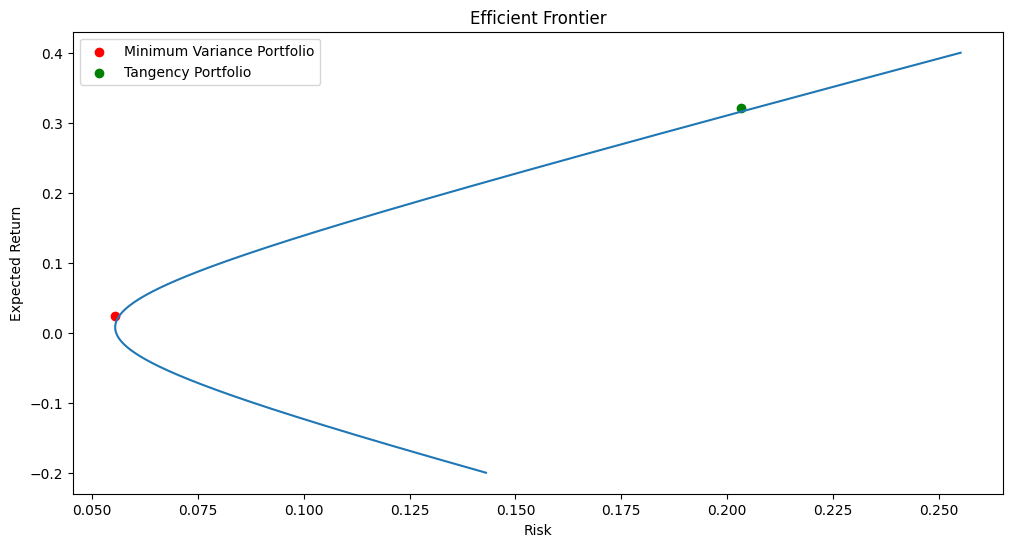

In [18]:
#Efficient Frontier
expected_return = np.arange(-0.2, 0.401, 0.001)
a = np.sum(np.matmul(np.matmul(marten_matrix, np.linalg.inv(cov_matrix)),marten_matrix))
b = np.sum(np.matmul(np.matmul(port_returns, np.linalg.inv(cov_matrix)), port_returns))
c = np.sum(np.matmul(np.matmul(port_returns, np.linalg.inv(cov_matrix)), port_returns))
d = a*c - b**2

risk = ((a*expected_return**2 - 2*b*expected_return + c)/d)**(1/2)
plt.figure(figsize=(12, 6))
plt.plot(risk, expected_return)
plt.scatter(mvp_risk, mvp_return, marker='o', color='r', label='Minimum Variance Portfolio')
plt.scatter(TP_risk, TP_return, marker='o', color='g', label='Tangency Portfolio')
plt.legend()
plt.xlabel('Risk')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.show()

Now let's evaluate the performance of the portfolio using the Sharp Ratio. It measuring the return generated above the risk-free rate relative to its risk.The higher the sharp ratio better the portfolio.
The Sharpe ratio is given by the formula:

$$
S = \frac{R_p - R_f}{\sigma_p}
$$

where \( S \) is the Sharpe ratio, \( R_p \) is the return of the portfolio, \( R_f \) is the risk-free rate, and \( \sigma_p \) is the standard deviation of the portfolio returns.

In [19]:
risk_free_rate = 0.02 #assuming
sharpe_ratio_MVP = (mvp_return -  risk_free_rate) / mvp_risk
sharpe_ratio_TP = (TP_return -  risk_free_rate) / TP_risk
sharp_ratios = pd.DataFrame({'Minimum Variance Portfolio':[sharpe_ratio_MVP], 'Tangency Portfolio':[sharpe_ratio_TP]})
print(f'Sharp Ratios: ')
sharp_ratios

Sharp Ratios: 


Minimum Variance Portfolio  Tangency Portfolio
0                    0.071138            1.483159

In [20]:
weights = pd.DataFrame({'Tickers':quotes.columns, 'Weights_Mean_Variance_Portfolio':mvp_weight,
                        'Weights_Tengency_Portfolio':TP_weight})
print(f'\033[1mStocks with negative weight are stocks with short position i.e we are buying put options\033[0m')
weights

Stocks with negative weight are stocks with short position i.e we are buying put options


Tickers  Weights_Mean_Variance_Portfolio  Weights_Tengency_Portfolio
0    TSLA                         0.000450                   -0.000362
1    AAPL                         0.011205                    0.210238
2    NVDA                        -0.006545                    0.338859
3     TSM                         0.008764                    0.069888
4    ABEV                         0.013833                   -0.191993
5    VTEB                         0.982981                    0.753168
6       V                         0.040544                    0.086203
7     AMD                        -0.005113                   -0.076581
8      BA                        -0.046118                   -0.189422

In summary, the Minimum Variance Portfolio (MVP) offers an expected return of 2.4% and a variance (risk) of 5.52%. It aims to balance risk and return efficiently. The Minimum-Variance Portfolio (MVP) is structured to minimize risk for a specified expected return of 2.5% i.e lowest possible risk for a given level of expected return of 2.5%. Additionally, the MVP has a Sharpe ratio of 0.076, indicating its risk-adjusted return.


Similarly, the Tangency Portfolio (TP) features an expected return of 30.85% with a risk of 19.69%. This portfolio boasts a Sharpe ratio of 1.465, highlighting its strong risk-adjusted performance. While the Tangency Portfolio achieves a high return with an acceptable variance of 19.69%, its performance in extreme situations warrants scrutiny. Hence, we will further evaluate the Value at Risk (VaR) of each portfolio.

# VaR

Value at Risk (VaR) measures the potential loss in value of a portfolio over a defined period for a given confidence interval. It basically answers What is the maximum potential loss that a portfolio might suffer with a specified confidence level over a certain period?

The Value at Risk (VaR) is given by the formula:

$$
\text{VaR}_{\alpha} =  \inf \{ x \in \mathbb{R} : P(L \leq x) > 1 - \alpha \}
$$

where VaR α is the Value at Risk at the confidence level
α, L is the loss random variable and P(L ≤ x) is the cumulative distribution function of the loss.




In [21]:
def VaR(portfolio_value, portfolio_types, window, confidence_intrval):
  hist_return = (log_return * portfolio_types).sum(axis=1)
  range_return = hist_return.rolling(window = window).sum().dropna()
  VaR = np.percentile(range_return, 100 - (1 - confidence_intrval) * 100)* portfolio_value
  print(f'VaR at {confidence_intrval: .0%} confidence level is $ {VaR}')
  range_return_doller = (range_return * portfolio_value).dropna()
  plt.figure(figsize=(12, 6))
  plt.hist(range_return_doller, bins=40, density=True)
  sns.kdeplot(range_return_doller, bw_adjust=0.5, color='blue')
  plt.ylabel('Frequency')
  plt.xlabel(f'{window}-Day Portfolio Return (Dollar Value)')
  plt.axvline(-VaR, color='r', linestyle='dashed', label=f'VaR at {confidence_intrval: .0%} confidence level')
  plt.title(f'Distribution of Portfolio {window}-Day Rolling window (Dollar Value)')
  plt.legend()
  plt.show()

VaR at  95% confidence level is $ 2666.7249025951705


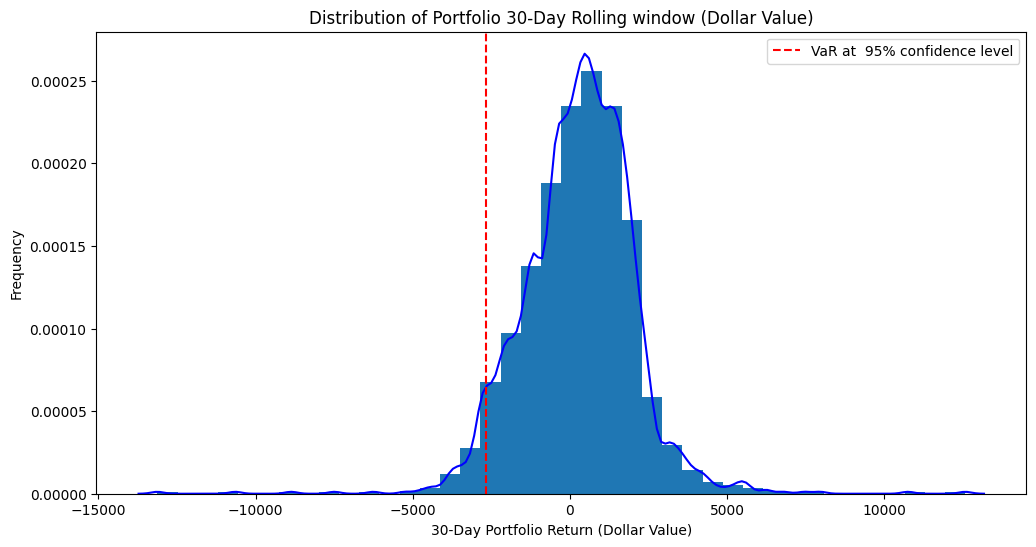

In [22]:
#VaR Minimum Variance Portfolio
Portfolo_value = 100000
portfolio_types = mvp_weight
window = 30
confidence_intrval = 0.95
VaR(Portfolo_value, portfolio_types, window, confidence_intrval)

VaR at  95% confidence level is $ 14941.49586451082


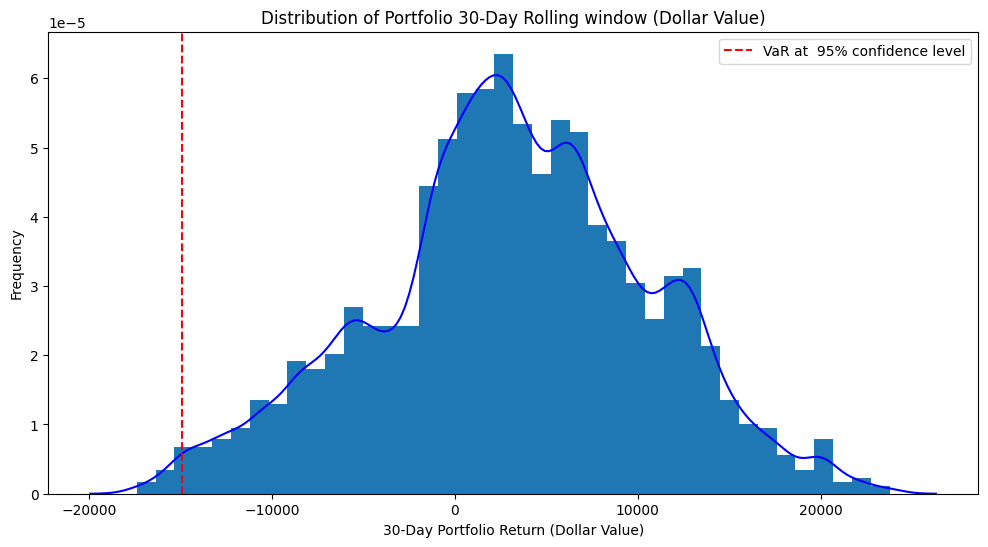

In [23]:
#VaR Tendency Portfolio
portfolio_types = TP_weight
VaR(Portfolo_value, portfolio_types, window, confidence_intrval)

**Now optimizing the desired return and the VaR associated with it.**

In [24]:
target_return = 0.05
h= np.matmul(marten_matrix, np.linalg.inv(cov_matrix))
g = np.matmul(port_returns, np.linalg.inv(cov_matrix))


if target_return < mvp_return:
  optimal_weight = mvp_weight
  optimal_return = mvp_return
  optimal_risk = mvp_risk
else:
  risk_optimizer = (c - b*target_return)/d
  return_optimizer = (a*target_return - b)/d
  risk_vect = risk_optimizer * h
  ret_vect = return_optimizer * g
  optimal_weight = risk_vect + ret_vect

  #optimal_weight = (risk*(np.matmul(np.linalg.inv(cov_matrix), marten_matrix))) + (returns * np.matmul(port_returns, np.linalg.inv(cov_matrix)))
  optimal_return = np.sum(optimal_weight * port_returns)
  optimal_risk = ((a*optimal_return**2 - 2*b*optimal_return + c)/d)**(1/2)

In [25]:
print(f'Optimal Weight: {optimal_weight}')
print(f'Optimal Return: {optimal_return}')
print(f'Optimal Risk: {optimal_risk}')

Optimal Weight: [ 3.82846222e-04  3.86076168e-02  3.86709554e-02  1.76587159e-02
 -1.22179491e-02  1.04095618e+00  5.02469710e-02 -1.50503282e-02
 -6.92718502e-02]
Optimal Return: 0.06555586968523007
Optimal Risk: 0.06652986738314544


VaR at  95% confidence level is $ 3930.860373981903


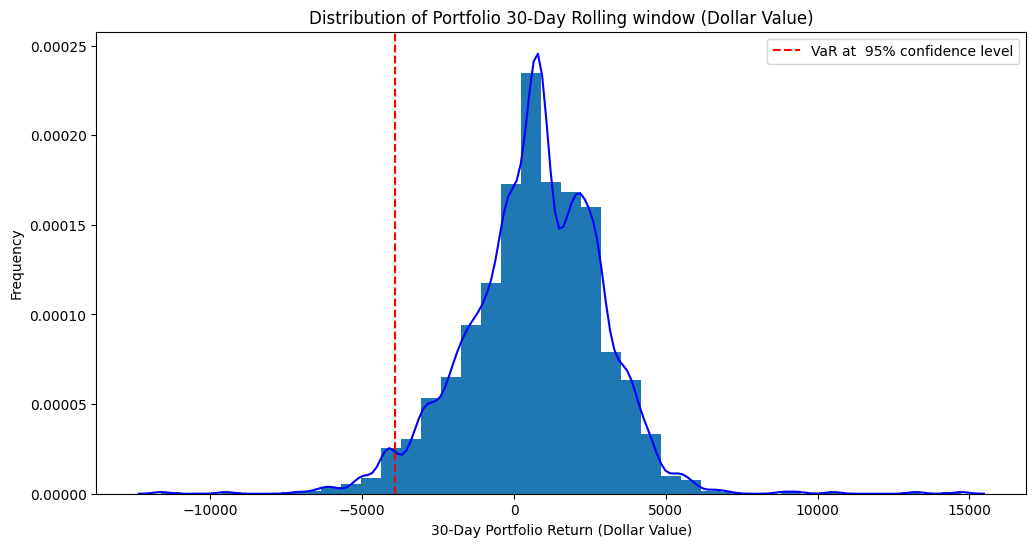

In [26]:
#Var for Desired Portfolio:
Portfolo_value = 100000
portfolio_types = optimal_weight
window = 30
confidence_intrval = 0.95
VaR(Portfolo_value, portfolio_types, window, confidence_intrval)

For our targeted portfolio return of 5%, with a initial portfolio value of 100000, the Value at Risk (VaR) for the 30-days rolling window is 38,601. We are  95% confident, that the maximum loss the portfolio will incure within 30 trading days is $3,894.







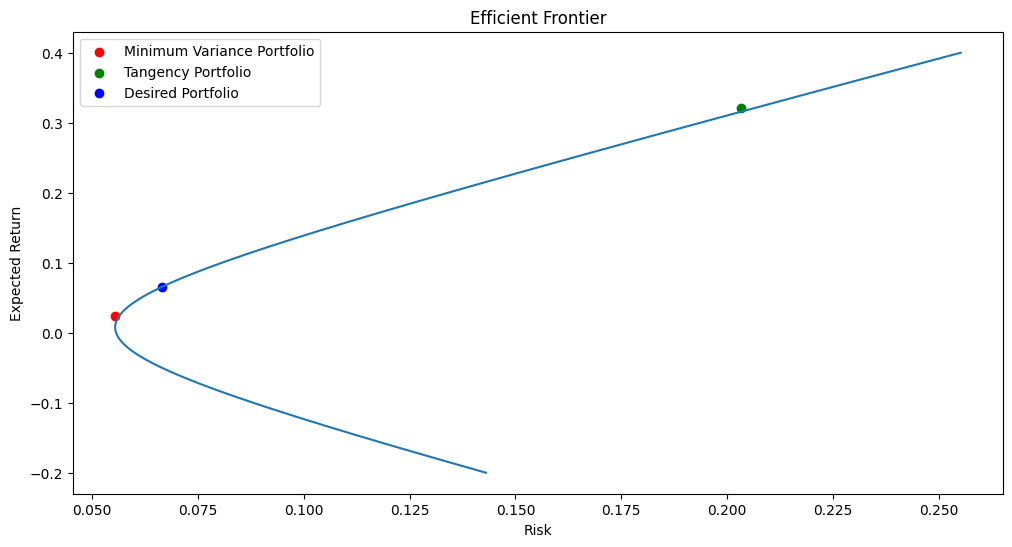

In [40]:
#Efficient Frontier including Desired Portfolio
expected_return = np.arange(-0.2, 0.401, 0.001)
a = np.sum(np.matmul(np.matmul(marten_matrix, np.linalg.inv(cov_matrix)),marten_matrix))
b = np.sum(np.matmul(np.matmul(port_returns, np.linalg.inv(cov_matrix)), port_returns))
c = np.sum(np.matmul(np.matmul(port_returns, np.linalg.inv(cov_matrix)), port_returns))
d = a*c - b**2

risk = ((a*expected_return**2 - 2*b*expected_return + c)/d)**(1/2)
plt.figure(figsize=(12, 6))
plt.plot(risk, expected_return)
plt.scatter(mvp_risk, mvp_return, marker='o', color='r', label='Minimum Variance Portfolio')
plt.scatter(TP_risk, TP_return, marker='o', color='g', label='Tangency Portfolio')
plt.scatter(optimal_risk, optimal_return, marker='o', color='b', label='Desired Portfolio')
plt.legend()
plt.xlabel('Risk')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.show()

**Simulting individual stocks and portfolio for 3 months using Path dependent Geometric Browanian Motion (GBM) using histotical volatility and drift**



$$ \text{Let S} = {[\ S_t : t >= 0]} $$
$$\text{If and only if}\ {S_{t}}\,\text{is continous and normally distributed with mean zero and variance of one.}$$
$$\text{Each increment in time is dependent of each other previous increment and is normally distributed with mean 0 and variance of t.}$$
$$\text{Such that:}\,\{S_{t+1} - S_t\, \,\exists\,\, N(0, t)\}$$
$$ \text{Then the process is given by}\,{dS_t = \mu S_t dt + \sigma S_t dW_t}
$$

Where,
α is drift coefficient

σ is the volatility coefficient

S0 is the intitial price of the assest

S1 is the price at time t

dSt is the infinitesimal increment of a stochastic process St






In [27]:
So = np.array(quotes.iloc[-1])
mu = np.array(log_return.mean())
log_return = np.log(quotes / quotes.shift(1))
sigma = np.array(log_return.std())
M = 200
T = 3 / 12  # 3 months
dt = 1 / 252  # daily
n = 100

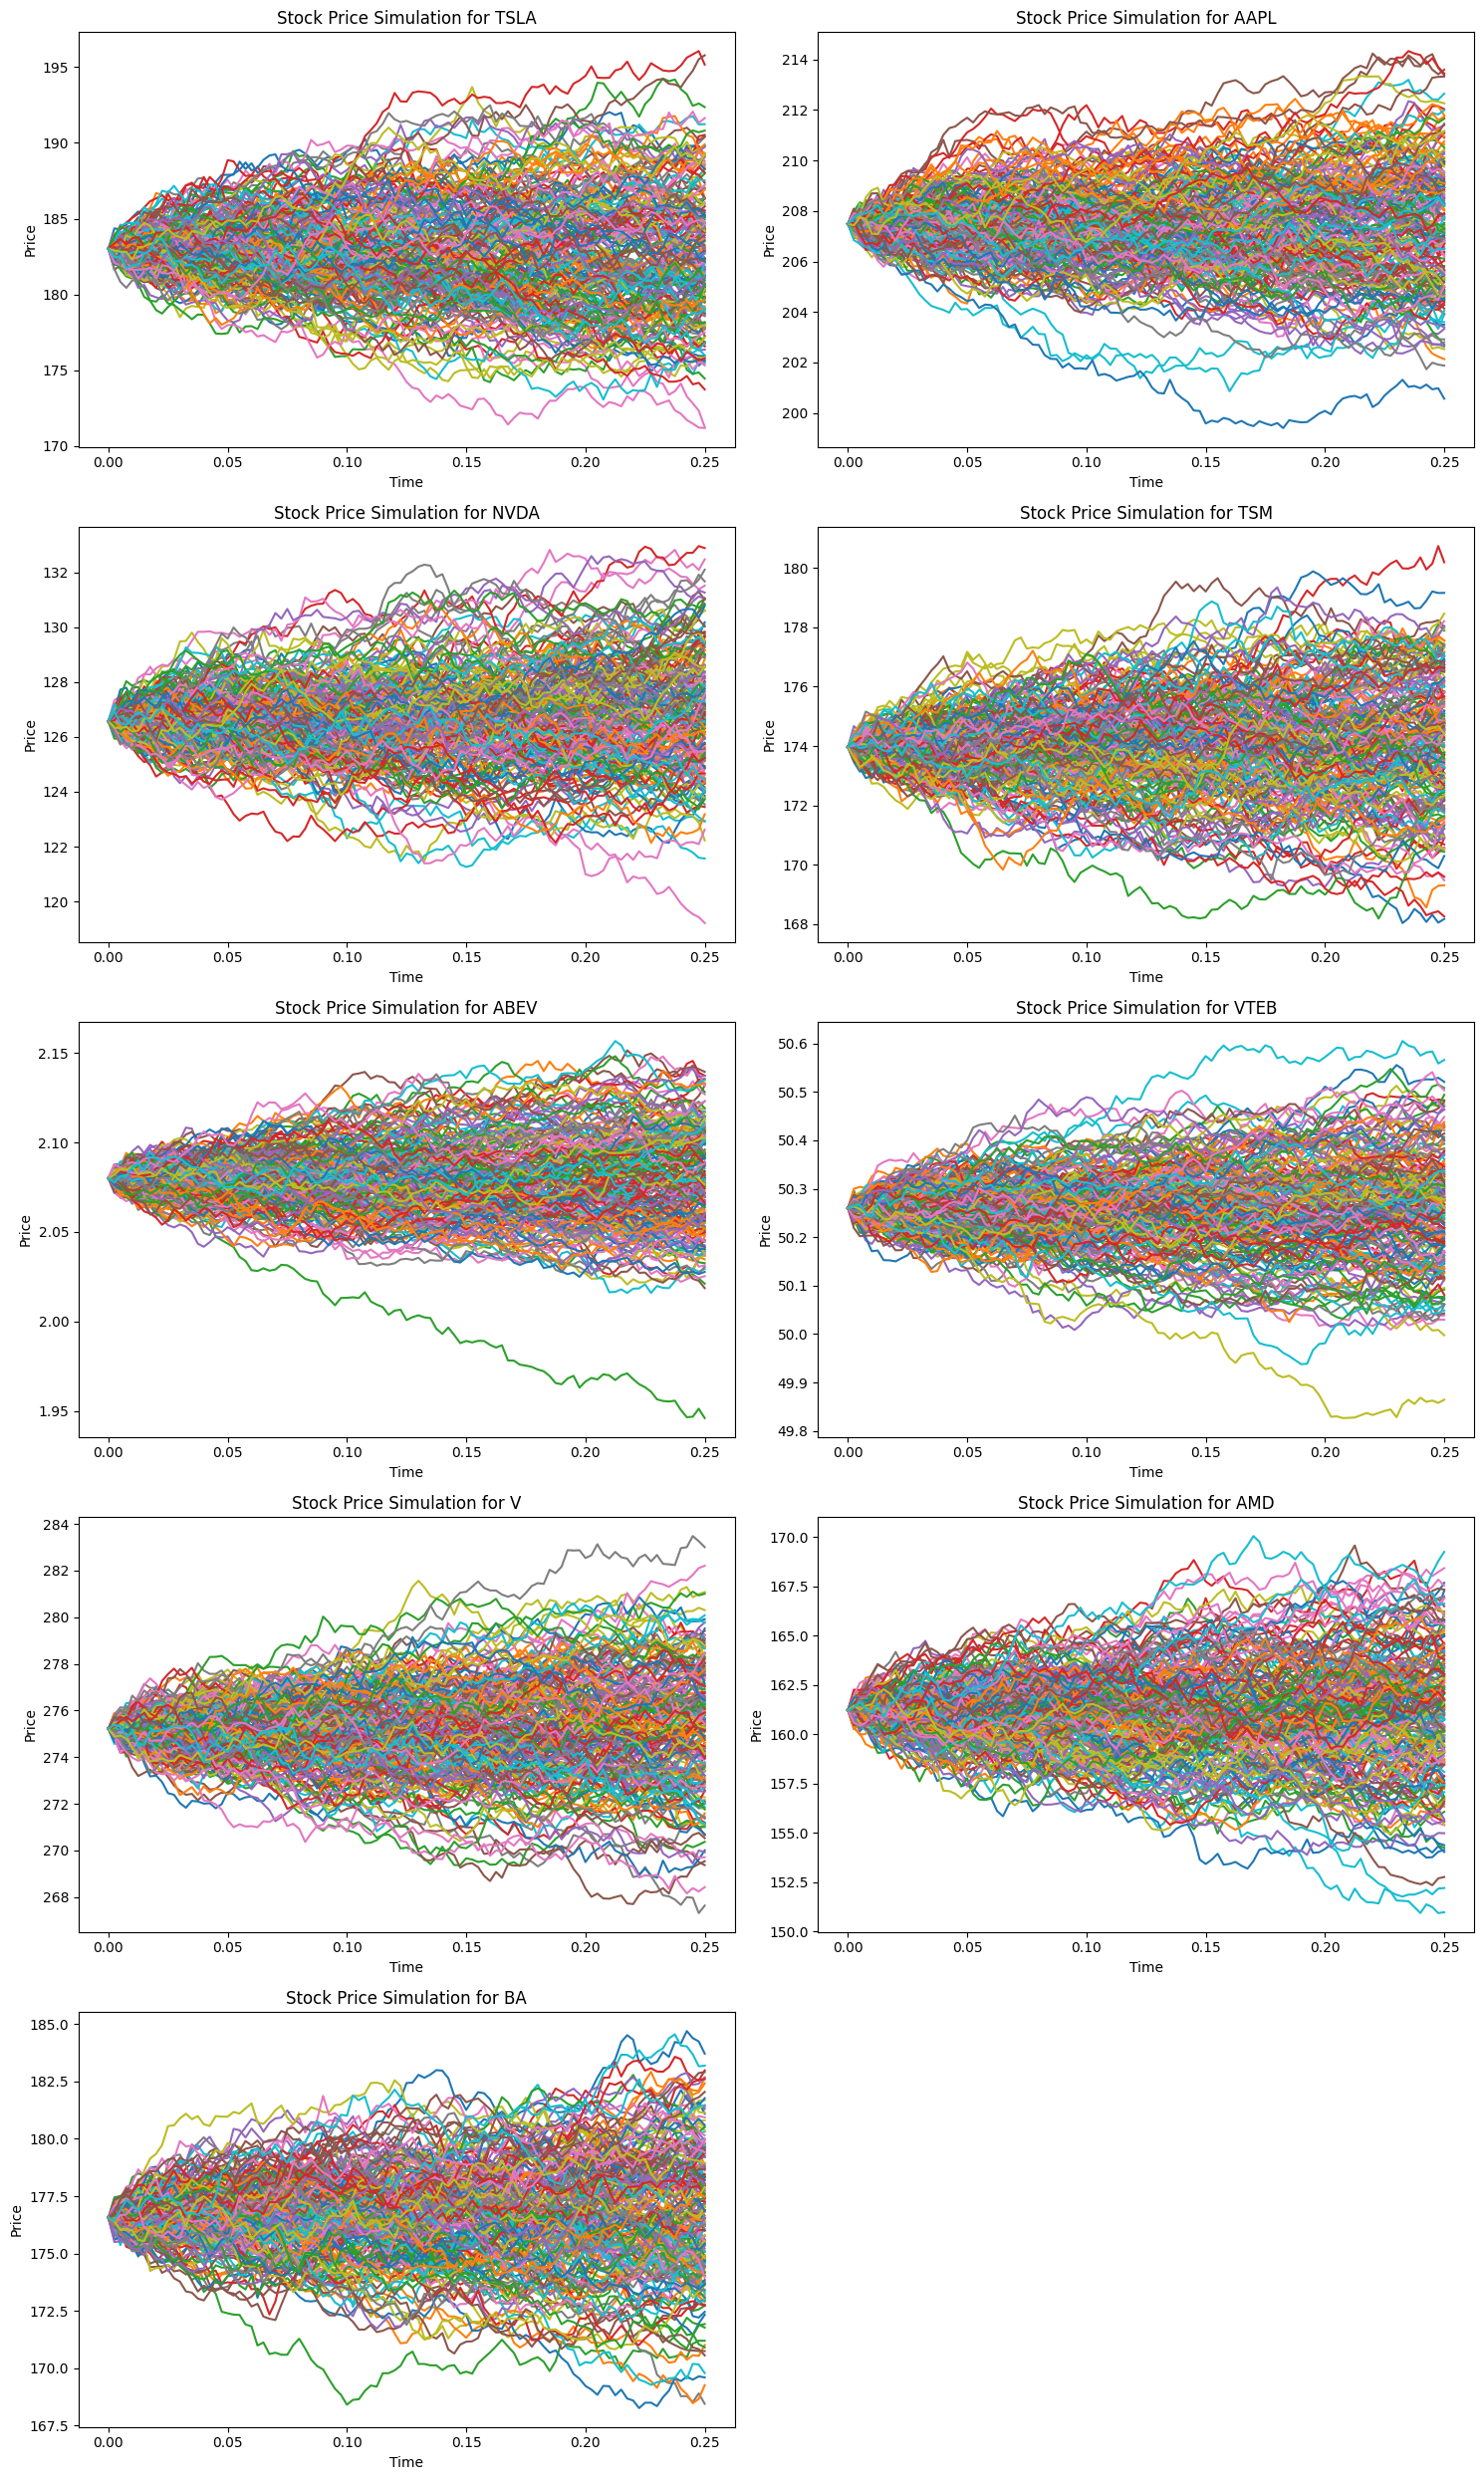

In [28]:
tickers = quotes.columns
num_stocks = len(tickers)
cols = 2
rows = (num_stocks + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for index, (s, m, sig, ticker) in enumerate(zip(So, mu, sigma, tickers)):
    st = np.exp((m - sig ** 2 / 2) * dt + sig * np.random.normal(0, np.sqrt(dt), size=(M, n)).T)
    st = np.vstack([np.ones(M), st])
    st = s * st.cumprod(axis=0)

    t = np.linspace(0, T, n + 1)
    tt = np.full(shape=(M, n + 1), fill_value=t).T

    ax = axes[index]
    ax.plot(tt, st)
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.set_title(f'Stock Price Simulation for {ticker}')

for ax in axes[num_stocks:]:
    ax.remove()

plt.tight_layout()
plt.show()


In [31]:
def simulate_portfolio(So, mu, sigma, title):
  So = 100000
  M = 50
  T = 3 / 12  # 3 months
  dt = 1 / 252  # daily
  n = 100

  st = np.exp((mu-sigma **2/2)*dt + sigma*np.random.normal(0, np.sqrt(dt), size=(M,n)).T)
  st = np.vstack([np.ones(M), st])
  st = So * st.cumprod(axis=0)
  t = np.linspace(0, T, n+1)
  tt = np.full(shape=(M,n+1), fill_value=t).T

  plt.figure(figsize=(12, 6))
  plt.plot(tt,st)
  plt.xlabel('Time')
  plt.ylabel('Price')
  plt.title(title)
  plt.show()

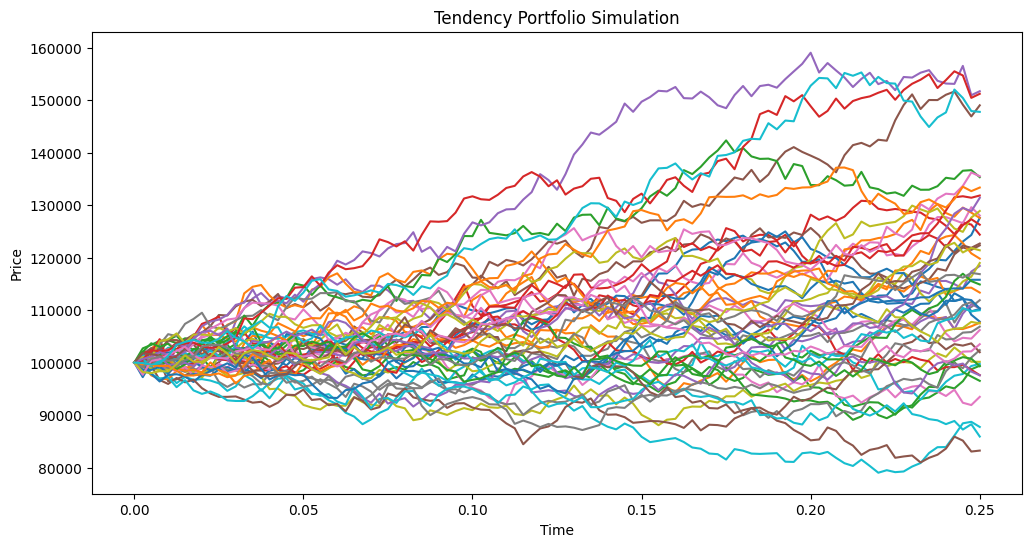

In [33]:
#Tendency Portfolio 3 Months Simulation
mu = 0.33
sigma = 0.20
simulate_portfolio(So, mu, sigma, 'Tendency Portfolio Simulation')

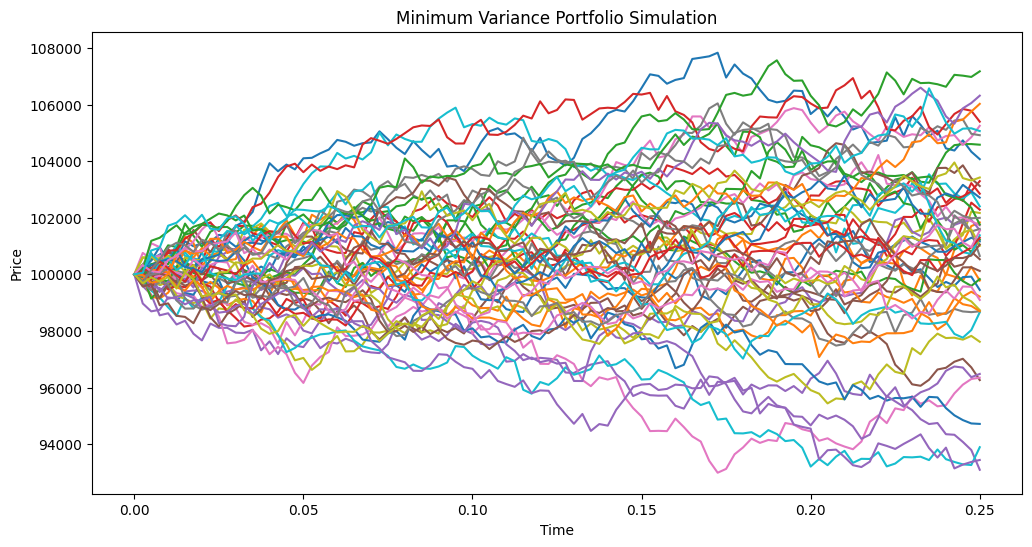

In [36]:
#Minimum Variance  Portfolio 3 months Simulation
mu =  0.025
sigma = 0.054
simulate_portfolio(So, mu, sigma, 'Minimum Variance Portfolio Simulation')

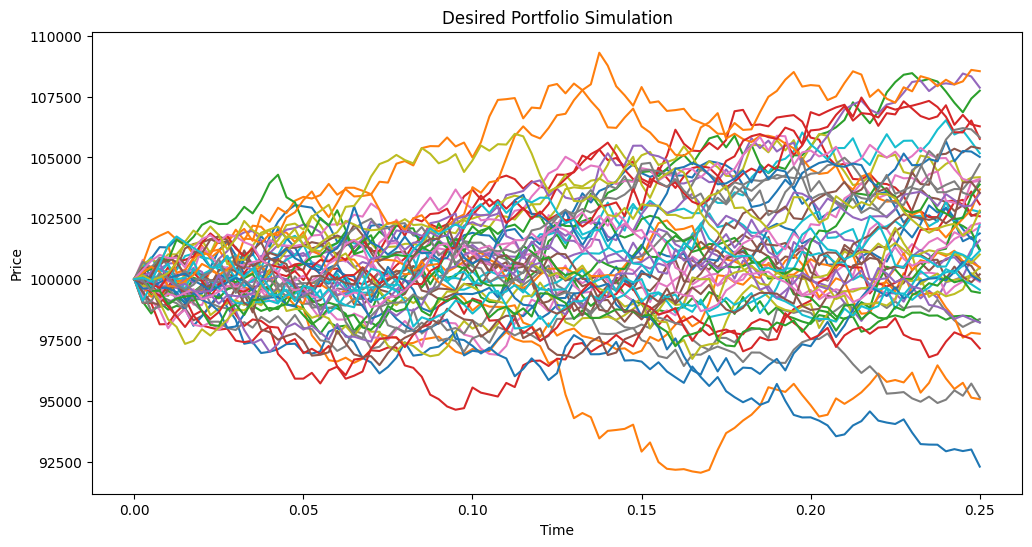

In [37]:
# Desired Portfolio 3 months Simulation
mu =  0.06
sigma = 0.066
simulate_portfolio(So, mu, sigma, 'Desired Portfolio Simulation')

In [39]:
!jupyter nbconvert --to html /content/Portfolio_Optimization_and_VaR_SDE.ipynb

[NbConvertApp] Converting notebook /content/Portfolio_Optimization_and_VaR_SDE.ipynb to html
[NbConvertApp] Writing 7143869 bytes to /content/Portfolio_Optimization_and_VaR_SDE.html
